In [42]:
# importing the good old libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from tqdm import tqdm_notebook
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


import os
print(os.listdir("../input"))


['digit-recognizer']


In [43]:
# importing the pytorch modules
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import optim

****Extracting Data****

In [44]:
# importing the training dataset
df=pd.read_csv("../input/digit-recognizer/train.csv")

In [45]:
df.shape

(42000, 785)

In [46]:
# Converting to numpy array
X=df.iloc[:,1:].values
Y=df.iloc[:,0].values

In [47]:
print(X.shape)
print(Y.shape)

(42000, 784)
(42000,)


In [48]:
df.iloc[:,0].value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [49]:
#StandardScaling the data

sc = StandardScaler()
X_scaled = sc.fit_transform(X)

In [50]:
# Reshaping the data to 
X_scaled= X_scaled.reshape(X_scaled.shape[0],1,28,28)

In [51]:
X_scaled.shape

(42000, 1, 28, 28)

**Printing the scaled image**

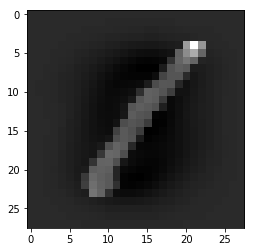

In [52]:
plt.imshow(X_scaled[0,0,:,:],cmap='gray')

**Printing the unscaled image**

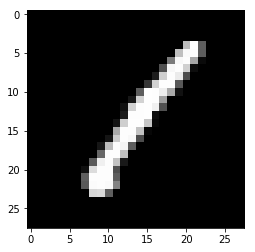

In [53]:
X= X.reshape(X.shape[0],1,28,28)
plt.imshow(X[0,0,:,:],cmap='gray')

In [54]:
from sklearn.model_selection import train_test_split
X_train,X_val,Y_train,Y_val=train_test_split(X_scaled,Y,test_size=0.25,stratify=Y,random_state=0)
print(X_train.shape,X_val.shape,Y_train.shape,Y_val.shape)

(31500, 1, 28, 28) (10500, 1, 28, 28) (31500,) (10500,)


In [55]:
# One hot encoding the data
# OH=OneHotEncoder()
# Y_OH_train=OH.fit_transform(Y_train.reshape(-1,1)).toarray()
# Y_OH_val=OH.transform(Y_val.reshape(-1,1)).toarray()

In [56]:
# Converting Numpy arrays to Pytorch Tensors after applying scaling
X_train,X_val,Y_train,Y_val = map(torch.tensor,(X_train,X_val,Y_train,Y_val))

In [57]:
X_train.size()

torch.Size([31500, 1, 28, 28])

In [58]:
# print(Y_OH_train.shape)
# print(Y_OH_val.shape)

**Creating the LeNet CNN**

In [59]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.cnn_model= nn.Sequential(
            nn.Conv2d(1,64,3), #(28,28,1)------>(26,26,64)
            nn.ReLU(),
            nn.Conv2d(64,64,3), #(26,26,64)------>(24,24,64)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2), # (24,24,64)------>(12,12,64)
            nn.Conv2d(64,128,3), # (12,12,64)-------->(10,10,128)
            nn.ReLU(),
            nn.Conv2d(128,128,3), # (10,10,128)-------->(8,8,128)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2) #(4,4,128)-------->(4,4,128)
            )
            
        self.fc_model=nn.Sequential(
            nn.Linear(2048,512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,10),
            nn.Softmax()
            )
            
        
    def forward(self,x):
#         print(x.shape)
        x = self.cnn_model(x)
#         print(x.shape)
        x = x.view(x.size(0),-1)
#         print(x.shape)
        x = self.fc_model(x)
#         print(x.shape)
        return x

In [60]:
# help(nn.LeakyReLU)

In [61]:
def accuracy(y_hat, y):
  pred = torch.argmax(y_hat, dim=1)
  return (pred == y).float().mean()

**Creating the fit function for our LeNet Class**

In [62]:
def fit(x, y, model, l_r, epochs=1000, mini_batch_size = 256):
    loss_arr=[]
    acc_arr=[]
    opt=optim.Adam(fn.parameters(),lr= l_r)
    m = x.shape[0]
    for epochs in range(epochs):
        for k in range(0, m, mini_batch_size):
            x_mini , y_mini = x[k:k+mini_batch_size], y[k:k+mini_batch_size]
            y_hat=fn(x_mini.float())
            loss=F.cross_entropy(y_hat, y_mini)
            loss_arr.append(loss.item())
            acc_arr.append(accuracy(y_hat, y_mini))
            loss.backward()
            opt.step()
            opt.zero_grad()
    plt.plot(loss_arr, 'r')
#     plt.plot(acc_arr,'b')
    plt.show()
    print('Loss before training', loss_arr[0])
    print('Loss after training', loss_arr[-1])
    print('Accuracy', acc_arr[-1])

In [63]:
#Taking data to GPU
device = torch.device("cuda")

X_train=X_train.to(device)
Y_train=Y_train.to(device)
X_val=X_val.to(device)
Y_val=Y_val.to(device)

In [64]:
X_train.shape[0]

31500

/opt/conda/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


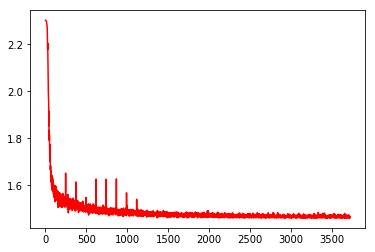

Loss before training 2.302628517150879
Loss after training 1.4611552953720093
Accuracy tensor(1., device='cuda:0')
Test accuracy: tensor(0.9814, device='cuda:0')


In [65]:
fn = LeNet().to(device)
fit(X_train, Y_train, fn, l_r= 0.0001, epochs=30
   )
print("Test accuracy:",accuracy(fn(X_val.float()), Y_val))